# Import libraries

In [60]:
# Directory, File Management
import os
from dotenv import load_dotenv
# Data Exploration
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Data Tracking
import mlflow
# Utils
from utils import image_to_pixels, preprocess_pixels
# Data Preprocessing, Evaluation
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
# ML Models
from xgboost import XGBClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [61]:
load_dotenv()
mlflow.set_tracking_uri(os.environ['MLFLOW_TRACKING_URI'])
mlflow.set_experiment('sudoku-digit-recognition')

<Experiment: artifact_location='mlflow-artifacts:/14f18a74de1c40b088c464a0d3a55c83', creation_time=1713456323645, experiment_id='0', last_update_time=1713456323645, lifecycle_stage='active', name='sudoku-digit-recognition', tags={}>

# Explore data

We have two datasets:
1. Chars74k (only Digits)
2. TMNIST (Typeface MNIST)

I have modified both datasets as following:  
- The Chars74k dataset contains a total of 9,144 images 1,016 images for each digit from 1~9.
- The TMNIST dataset contains a total of 26,910 images 2,990 images for each digit from 1~9.

Modifications to the datasets:  
- I have erased all the 0 digit images and pixel rows in both datasets for various reasons. We have to take into account that there is no need for our digit recognition model to recognize the digit '0' because we are creating a model specialized for Sudoku. As a reminder, Sudoku is a puzzle that involves only the digits from 1-9.  
- Also, I dropped the 'names' column from the TMNIST dataset as the font-family doesn't provide much information for classification.
- I have only collected datasets such that the amount of images are equal for each of the digits because on my first attempt to doing this project, I noticed that during the softmax layer to classify a digit, when the model is unsure of the digit, it will be biased to predict the number with the most frequency in the training set. For my first attempt the distribution of the dataset had been unbalanced with having more 1's than any other digit and so for digits that look similar such as 7 or 9 when the model was unsure it would predict 1.
- finally, I inverted the pixel values from the TMNIST because I realized that the font is white and the background is black. So I subtracted the pixel values from 255.

p.s. Also, I am not including handwritten digits from datasets such as MNIST in this project because those digit formats are irrelevant to a Sudoku puzzle, which is mostly printed or made with computer fonts.

Some advantages of doing so:
1. by focusing on the digits that are relevant to the task, the model will be more specialized and better suited for the intended application.
2. it simplifies the training process and reduces the complexity of the model, leading to a faster training time and potentially better performance on the digits relevant to the task.
3. it helps balance the distribution of digits in the dataset preventing the model from being biased towards the majority class (1-9) and improve its ability to generalize.
4. reduce some bias and noise to the model.

Now we will try to match all the images from the chars74k dataset to a pandas dataframe like the TMNIST_Data.csv so that we can concatenate them in the same format.

In [62]:
# directory_path = './images/chars74k'

# row_list = []
# for folder in os.listdir(directory_path)[1:]:
#     subfolder = os.path.join(directory_path, folder)
#     for file in os.listdir(subfolder):
#         file = os.path.join(subfolder, file)
#         image = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
#         image = cv2.resize(image, (28,28))
#         flatten_image = image.flatten()
#         data = {'labels': int(folder), **{f'{i+1}': value for i, value in enumerate(flatten_image)}}
#         row_list.append(data)
# df_chars74k = pd.DataFrame(row_list)

Let's save the dataset as a csv.

In [63]:
# df_chars74k.to_csv('./data/chars74k.csv', index=False)

Let's see a random image from both datasets and see that the pixel sizes and the grayscale match.

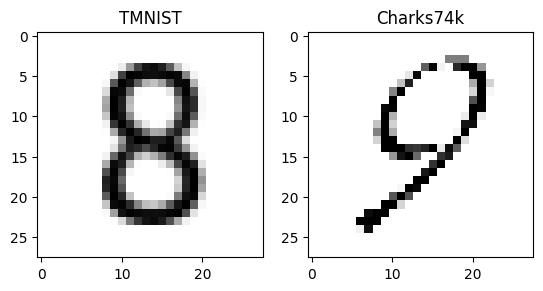

In [64]:
df_tmnist = pd.read_csv('./data/tmnist.csv')
tmnist_2d = np.reshape(df_tmnist.iloc[1,1:], (28,28)).astype(np.uint8)
df_chars74k = pd.read_csv('./data/chars74k.csv')
chars74k_2d = np.reshape(df_chars74k.iloc[1,1:], (28,28)).astype(np.uint8)

plt.subplot(1,2,1)
plt.imshow(tmnist_2d, cmap='gray')
plt.title('TMNIST')
plt.subplot(1,2,2)
plt.imshow(chars74k_2d, cmap='gray')
plt.title('Charks74k')

plt.show()

Now let's vertically concatenate both datasets into one dataframe.

In [65]:
df = pd.concat([df_tmnist, df_chars74k], axis=0)
df

,labels,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,2,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
1,8,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
2,4,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
3,3,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
4,1,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9139,5,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
9140,5,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
9141,5,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
9142,5,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255


Now let's check once again that the distribution is uniform.

In [66]:
# df['labels'].value_counts().sort_index()

In [67]:
# plt.bar(df['labels'].value_counts().index, df['labels'].value_counts().values)
# plt.title('Label Distribution')
# plt.xlabel('Label')
# plt.ylabel('Counts')
# plt.xticks(df['labels'].value_counts().index)
# plt.show()

Now we have to make augmentation of blank images and we will make the model predict them as 0. I will take screenshots of blank boxes with a little bit of the border left in the image and make enough augmented images to match the distribution of the dataset.

In [68]:
# image_folder = "./images/blank"
# image_paths = [os.path.join(image_folder, img) for img in os.listdir(image_folder) if img.endswith(".png")]

# datagen = ImageDataGenerator(
#     rotation_range=0,  # Disable random rotation
#     horizontal_flip=True,
#     vertical_flip=True)

# num_images = len(image_paths)
# images_per_image = 4006 // num_images
# remainder = 4006 % num_images

# output_folder = "./images/blank_aug"
# if not os.path.exists(output_folder):
#     os.makedirs(output_folder)

# for image_path in image_paths:
#     img = load_img(image_path)
#     x = img_to_array(img)

#     i = 0
#     num_augmentations = images_per_image
#     if remainder > 0:
#         num_augmentations += 1
#         remainder -= 1

#     while i < num_augmentations:
#         for angle in [90, 180, 270]:
#             x_aug = datagen.apply_transform(x, {'theta': angle})
#             x_aug = x_aug.reshape((1,) + x_aug.shape)  # Reshape to (1, height, width, channels)
#             for batch in datagen.flow(x_aug, batch_size=1, save_to_dir=output_folder, save_prefix='aug', save_format='png'):
#                 i += 1
#                 if i >= num_augmentations:
#                     break

Now we will repeat the same process as the Chars74k dataset and make these augmented blank images into a pandas dataframe with labels 0 and 784 columns with the pixel values in grayscale.

In [69]:
# directory_path = './images/blank_aug'

# row_list = []
# for file in os.listdir(directory_path):
#     file = os.path.join(directory_path, file)
#     image = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
#     image = cv2.resize(image, (28,28))
#     flatten_image = image.flatten()
#     data = {'labels': 0, **{f'{i+1}': value for i, value in enumerate(flatten_image)}}
#     row_list.append(data)
# df_blank = pd.DataFrame(row_list)
# df_blank

After checking on some of the images there were some that were completely black for some unknown reason so we will track all of the images that are completely black and revert them to white blank images.

In [70]:
# df_blank_0s = (df_blank.iloc[:, 1:] == 0).all(axis=1)

# df_blank.loc[df_blank_0s, df_blank.columns[1:]] = 255

In [71]:
# df_blank

Now let's concatenate it to the main dataset.

In [72]:
# df = pd.concat([df, df_blank], axis=0)
# df

Let's check the distribution once again.

In [73]:
# plt.bar(df['labels'].value_counts().index, df['labels'].value_counts().values)
# plt.title('Label Distribution')
# plt.xlabel('Label')
# plt.ylabel('Counts')
# plt.xticks(df['labels'].value_counts().index)
# plt.show()

The augmentation worked and the 0 labels have a lower distribution than the other labels, but there isn't a lot of features in blank images so this seems okay. It seems to be really hard to for the tensorflow.keras.processing.image DataGenerator to work with the blank images.

Now we save the concatenated data so that from now on we can work with the full dataset csv and can comment out all of the process above.

In [74]:
# df.to_csv('./data/digit_recognition.csv', index=False)
# df

# Split Data into Train, Validation, Test Sets

In [89]:
df = pd.read_csv('./data/digit_recognition.csv')
# df = df.loc[df['labels']!=0]
df

,labels,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,2,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
1,8,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
2,4,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
3,3,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
4,1,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39373,0,15,15,15,15,15,15,15,15,15,...,255,255,255,255,255,253,252,36,16,21
39374,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39375,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39376,0,7,34,34,34,34,34,34,34,34,...,255,255,253,253,253,253,253,253,253,255


Now the data will be separated into X and y then we split the train, validation, and test sets with stratified sampling on the labels.

The steps will be:
1. separate the X and y.
2. check the shape to make sure the dimensions are right.
3. separate into train and test sets with the stratify parameter being the label feature.
4. separate into train and val sets with the stratify parameter being the label features again.
5. then drop the label column from X because it was only used for stratification.
6. check the shape to make sure the dimensions are right again.

In [90]:
X_train, X_test, y_train, y_test = train_test_split(df, df.iloc[:,0], test_size=0.1, stratify=df.iloc[:,0])
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, stratify=X_train.iloc[:,0])

Now lets check that the shapes are correct. 

In [91]:
print(f'{X_train.shape = }')
print(f'{y_train.shape = }')
print(f'{X_val.shape = }')
print(f'{y_val.shape = }')
print(f'{X_test.shape = }')
print(f'{y_test.shape = }')

X_train.shape = (31896, 785)
y_train.shape = (31896,)
X_val.shape = (3544, 785)
y_val.shape = (3544,)
X_test.shape = (3938, 785)
y_test.shape = (3938,)


Now we can drop the label columns for all the X datasets as it was only left there for stratification.

In [92]:
X_train.drop(columns='labels', inplace=True)
X_val.drop(columns='labels', inplace=True)
X_test.drop(columns='labels', inplace=True)

In [93]:
print(f'{X_train.shape = }')
print(f'{y_train.shape = }')
print(f'{X_val.shape = }')
print(f'{y_val.shape = }')
print(f'{X_test.shape = }')
print(f'{y_test.shape = }')

X_train.shape = (31896, 784)
y_train.shape = (31896,)
X_val.shape = (3544, 784)
y_val.shape = (3544,)
X_test.shape = (3938, 784)
y_test.shape = (3938,)


We will convert all the datasets to numpy arrays.

In [94]:
X_train = X_train.to_numpy()
X_val = X_val.to_numpy()
X_test = X_test.to_numpy()

y_train = y_train.to_numpy()
y_val = y_val.to_numpy()
y_test = y_test.to_numpy()

Finally let's normalize the data.

In [95]:
mm_scaler = MinMaxScaler()

In [96]:
X_train_scaled = mm_scaler.fit_transform(X_train)
X_val_scaled = mm_scaler.transform(X_val)
X_test_scaled = mm_scaler.transform(X_test)
# y_train, y_val, y_test = y_train -1, y_val-1, y_test-1
# X_train_255, X_val_255, X_test_255 = X_train / 255, X_val / 255, X_test / 255

In [97]:
# X_train_255, X_val_255, X_test_255 = X_train / 255, X_val / 255, X_test / 255
# from numpy.testing import assert_almost_equal
# assert_almost_equal(X_train_255, X_train_scaled)
# assert_almost_equal(X_val_255, X_val_scaled)
# assert_almost_equal(X_test_255, X_test_scaled)

# Machine Learning

In this step we will perform machine learning. We will use different models and compare their evaluations to decide which one to use.  

The three models that I will try are:
1. XGBoost (Ensemble Random Forest), 
2. Neural Network, 
3. Convolutional Neural Network.

## XGBoost

In [98]:
with mlflow.start_run(run_name="XGBClassifier"):
    params = {
        'objective': 'multi:softmax',
        'num_class': 10,
        'max_depth': 6,
        'learning_rate': 0.3,
        'n_estimators': 100
    }
    mlflow.log_params(params)

    xgb = XGBClassifier(
        objective='multi:softmax',
        num_class=10,  
        max_depth=6,  
        learning_rate=0.3,  
        n_estimators=100
    )
    xgb.fit(X_train_scaled, y_train)

    y_val_pred = xgb.predict(X_val_scaled)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    print("Validation Accuracy:", val_accuracy)

    y_test_pred = xgb.predict(X_test_scaled)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    print("Testing Accuracy:", test_accuracy)

    conf_matrix = confusion_matrix(y_test, y_test_pred)
    print("Confusion Matrix:")
    print(conf_matrix)
    
    f1 = f1_score(y_test, y_test_pred, average='weighted')
    print("F1 Score:", f1)
    
    metrics = {
        'val_accuracy': val_accuracy,
        'test_accuracy': test_accuracy,
        # 'confusion_matrix': conf_matrix,
        'f1_score': f1
    }
    
    xgb.save_model('./models/xgb.json')
    
    mlflow.log_metrics(metrics)
    
    # plt.figure(figsize=(8, 6))
    # sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d')
    # plt.xlabel('Predicted labels')
    # plt.ylabel('True labels')
    # plt.title('Confusion Matrix')
    # plt.savefig('confusion_matrix.png')
    # plt.close()
    # mlflow.log_artifact('confusion_matrix.png')
    
    mlflow.xgboost.log_model(xgb, "xgboost-model")
    

Validation Accuracy: 0.9830699774266366
Testing Accuracy: 0.9834941594718131
Confusion Matrix:
[[332   0   0   0   0   0   0   0   0   0]
 [  0 393   2   0   1   0   0   4   0   1]
 [  0   4 393   1   0   0   1   0   0   1]
 [  0   3   1 392   0   2   1   2   0   0]
 [  0   3   0   0 396   0   0   0   0   2]
 [  0   0   0   0   0 397   2   0   1   0]
 [  0   0   0   0   3   4 391   0   3   0]
 [  0   3   0   1   0   1   0 394   1   1]
 [  0   2   2   0   0   1   1   1 393   1]
 [  0   0   0   1   3   0   0   2   2 392]]
F1 Score: 0.9835028620113444


/Users/robertopark/Documents/code-projects/datascience-projects/sudoku-solver-app/.venv/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:53:03] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


In [101]:
rel_path = './images/toy/'
for image in os.listdir(rel_path):
    if image.startswith('sudoku') and image.endswith('.png'):
        print(f'{image = }')
        image = cv2.imread(rel_path+image)

        image = image_to_pixels(image, (28,28)).flatten()
        image = mm_scaler.transform([image])
        image = image.reshape(1, -1)
        predictions = xgb.predict(image, output_margin=True)

        print(f'Prediction Label: {predictions.argmax()}')
        print(f'Prediction Score: {predictions.round(3)}')

image = 'sudoku-1.png'
Prediction Label: 1
Prediction Score: [[-5.629  7.266 -6.219 -3.007 -1.332 -2.413 -7.072 -3.235 -5.939 -4.674]]
image = 'sudoku-2.png'
Prediction Label: 2
Prediction Score: [[-5.629 -5.412  9.947 -3.251 -6.991 -6.121 -5.259 -3.297 -4.292 -4.157]]
image = 'sudoku-3.png'
Prediction Label: 3
Prediction Score: [[-5.629 -5.323 -4.299  5.993 -6.001 -4.046 -6.105 -4.275 -2.556 -4.523]]
image = 'sudoku-7.png'
Prediction Label: 7
Prediction Score: [[-5.594 -4.681 -1.634 -3.75  -4.95  -5.641 -6.953  6.095 -2.538 -4.673]]
image = 'sudoku-6.png'
Prediction Label: 6
Prediction Score: [[-5.629 -6.417 -5.477 -6.001 -5.004 -3.145  3.914 -6.502  2.938 -5.955]]
image = 'sudoku-4.png'
Prediction Label: 4
Prediction Score: [[-5.588 -3.868 -4.686 -5.062 10.236 -4.619 -3.696 -6.317 -2.467 -4.939]]
image = 'sudoku-5.png'
Prediction Label: 5
Prediction Score: [[-5.629 -5.546 -5.826 -5.75  -5.341  8.298 -0.88  -6.487 -4.028 -5.618]]
image = 'sudoku-blank.png'
Prediction Label: 7
Predicti

## Neural Network

## Convolutional Neural Network

For a CNN you need to preprocess the pixels before you feed them into the model.

# Preprocess images for Convolutional Neural Network

As we can see, the X holds the value of file path to the image and so we need to be able to get the images in those file paths, convert those images into pixel values and then make each pixel value be one feature or column in the new X.

Until now we were exploring and cleaning data from different datasets with different structures but now that we have combined and we are ready for preprocessing the data for machine learning, we will be using functions later to be saved in the utils.py.

In [ ]:
import cv2
import numpy as np
def df_to_pixels_array(df:pd.DataFrame, label:str, resize_dim:tuple, rel_path) -> np.array:
    """
    Takes a column from a pandas dataframe that has the values for the file path of images.
    Then it reads the files, converts them to grayscale and flattens the pixel values
    to finally return a numpy array of those values.

    Parameters:
    df_filepath (dataframe): The dataframe to process.
    label (string): The name of the column containing the file paths
    resize (tuple): The dimensions to resize the image before flattening.
    rel_path (string): The relative file path before the value in the dataframe column.

    Returns:
    array: (m, n) numpy array of grayscale pixel values.
            m -> # of images
            n -> product of resize tuple provided
    """
    i = len(df[label])
    m = resize_dim[0]
    n = resize_dim[1]
    df_array = np.zeros((i, m, n), dtype=np.uint8)
    for index, file_path in enumerate(df[label]):
        file_path = rel_path + file_path
        image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
        image = cv2.equalizeHist(image)
        image = cv2.resize(image, resize_dim)
        if image is None:
            print("Error: Unable to read the image.")
            print(file_path)
        else:
            df_array[index] = image
    return df_array

In [ ]:
rel_path = './images/numbers/'
label = 'file'
resize_dim = (32,32)
X_train = df_to_pixels_array(X_train, label, resize_dim, rel_path)
X_val = df_to_pixels_array(X_val, label, resize_dim, rel_path)
X_test = df_to_pixels_array(X_test, label, resize_dim, rel_path)


Let's check that the dimensions and datatypes are correct for X_train, X_val, and X_test.

In [ ]:
print(f'{X_train.shape = }')
print(f'{X_val.shape = }')
print(f'{X_test.shape = }')

Now it is time for further preprocessing before we train the Convolutional Neural Network for it to be able to predict numbers.  
Specifically, we are going to normalize the data. Right now, the range of each pixel is from 0, 255 with 0 being black and 255 white. By normalizing the data the range will be from 0~1 conserving the ratio, and this will help the model to converge more efficiently.

In [ ]:
X_train = tf.keras.utils.normalize(X_train, axis=1)
X_train = np.array(X_train).reshape(-1, resize_dim[0], resize_dim[1], 1)
X_val = tf.keras.utils.normalize(X_val, axis=1)
X_val = np.array(X_val).reshape(-1, resize_dim[0], resize_dim[1], 1)
X_test = tf.keras.utils.normalize(X_test, axis=1)
X_test = np.array(X_test).reshape(-1, resize_dim[0], resize_dim[1], 1)

# Build Convolutional Neural Network Model to train and test

Then we build the arquitecture for the CNN and compile the model.

In [ ]:
model = Sequential(
    [
        Conv2D(32, (3,3), padding='valid', activation='relu', input_shape=(X_train.shape[1:])),
        BatchNormalization(),
        Conv2D(32, (3,3), padding='valid', activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2,2)),
        Dropout(0.25),

        Conv2D(64, (3,3), padding='valid', activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2,2)),
        Conv2D(64, (3,3), padding='valid', activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2,2)),
        Dropout(0.25),

        Flatten(),
        Dense(512,activation='relu'),
        BatchNormalization(),
        Dropout(0.25),
        Dense(1024,activation='relu'),
        BatchNormalization(),
        Dropout(0.25),
        Dense(9, activation='softmax')
    ]
)
optimizer = Adam(learning_rate=0.0001)
model.compile(
    optimizer=optimizer, 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)

model.summary()

Before we fit the model we are going to generate batches of augmented data for the X_train and y_train.

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min')
model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=100, callbacks=[early_stopping])

In [ ]:
# datagen = ImageDataGenerator(
#     rotation_range=10,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     # horizontal_flip=True,
#     fill_mode='nearest'
# )
# datagen.fit(X_train)
# train_generator = datagen.flow(X_train, y_train-1, batch_size=32)
# model.fit(train_generator, validation_data= (X_val, y_val-1), epochs=5)
model.fit(X_train, y_train, validation_data= (X_val, y_val), epochs=50, batch_size=32)

Fit the model to the train data, and subtract 1 from y_train as the outputlayer contains 1~9 but counting starts from 0.

In [ ]:
# model.fit(X_train, y_train - 1, epochs=3, validation_split=0.2, batch_size=32, verbose='auto')

Evaluate the model to see how it did on the test data.

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'{loss = }')
print(f'{accuracy = }')

Make some functions to preprocess the images for the models to predict

In [ ]:
def image_to_pixels(image:np.array) -> np.array:
    resize_dim = (32, 32)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    equalized_image = cv2.equalizeHist(gray_image)
    image = cv2.resize(equalized_image, resize_dim)
    return image

In [ ]:
def preprocess_pixels(image:np.array) -> np.array:
    resize_dim = (32,32)
    normalized_image = tf.keras.utils.normalize(image, axis=1)
    preprocessed_image = np.array(normalized_image).reshape(-1, resize_dim[0], resize_dim[1], 1)
    return preprocessed_image

Try to see how well the model predicts with toy data from self made handwritten digits, which is not that very important compared to the actual digits that real Sudoku would hold (mostly computer font digits).

In [ ]:
import os
directory = './images/toy/'
files = os.listdir(directory)
# resize_dim = (32,32)
for file in files:
    if file == '2022-us-sudoku-grand-prix-round.png':
        pass
    else:
        full_path = directory + file
        image = cv2.imread(full_path)
        image = image_to_pixels(image)
        image = preprocess_pixels(image)
        prediction = model.predict(image)
        prediction_label = prediction.argmax() + 1
        predicted_probability = prediction.max()
        print(f'{file = }')
        print(f'{prediction.round(3) = }')
        print(f'{prediction_label = }')
        print(f'{predicted_probability = }')
        

We can see that the model performs above 95% on the real Sudoku digits, so we will save the model.

In [ ]:
model.save('./models/cnn_8.h5')

After a lot of trial and error we reached the best model so far being the cnn_5.h5 model.